In [67]:
import os
import pandas as pd
import torch
import xml.etree.ElementTree as ET
from PIL import Image 
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
import cv2 as cv

import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor


In [2]:
files_dir = 'dataset_fruit/train_zip/train'
test_dir = 'dataset_fruit/test_zip/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [109]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df, files_dir, S=7, B=2, C=3, transform=None, image_size=(416, 416)):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.image_size = image_size
        self.resize = Resize(self.image_size)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()

        class_dictionary = {'apple': 0, 'banana': 1, 'orange': 2}

        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")

        img_width, img_height = image.size
        for member in root.findall('object'):
            klass = member.find('name').text
            klass = class_dictionary[klass]
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            centerx = ((xmax + xmin) / 2) / img_width
            centery = ((ymax + ymin) / 2) / img_height
            boxwidth = (xmax - xmin) / img_width
            boxheight = (ymax - ymin) / img_height

            boxes.append([klass, centerx, centery, boxwidth, boxheight])

        boxes = torch.tensor(boxes)
        image = self.resize(image)
        image = ToTensor()(image)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, 5 * self.B + self.C))

        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            # Remove the * self.S scaling for width and height
            width_cell, height_cell = width, height

            for b in range(self.B):
                if label_matrix[i, j, 5 * b + 4] == 0:  
                    label_matrix[i, j, 5 * b:5 * b + 5] = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell, 1] 
                    )
                    break

            label_matrix[i, j, 5 * self.B + class_label] = 1

        return image, label_matrix

In [110]:


BATCH_SIZE = 16

train_dataset = FruitImagesDataset(files_dir=files_dir, df=df)

test_dataset = FruitImagesDataset(files_dir=files_dir, df=df)

In [132]:
def draw_bbox(im, label, conf_thresh=0.8):
    S = 7
    B = 2
    C = 3
    image = im.permute(1, 2, 0).numpy()
    image = image.copy()
    image = (image * 255).astype('uint8')
    img_height, img_width = image.shape[:2]
    section_width = img_width / S
    section_height = img_height / S
    
    for i in range(S):
        for j in range(S):
            grid = label[i, j]   
            bbox1_conf = grid[4]
            bbox2_conf = grid[9]
            
            if(bbox1_conf >= bbox2_conf):
                bbox = grid[:5]
                conf = bbox1_conf
            else:
                bbox = grid[5:10]
                conf = bbox2_conf
                
            if conf < conf_thresh:
                continue    
            
            '''
                The (x, y) coordinates represent the center of the box #* relative to the bounds of the grid cell. 
                The width and height are predicted #* relative to the whole image.
            '''

            x, y, w, h = bbox[:4].tolist()
            
            cell_x = j * section_width
            cell_y = i * section_height
            
            # Cell responsible for bbox
            cv.rectangle(image, (int(cell_x), int(cell_y)),
                                (int(cell_x + section_width), int(cell_y + section_height)),
                                (0, 255, 0), 2)
            
            center_x = cell_x + x * section_width
            center_y = cell_y + y * section_height
            
            # center
            cv.circle(image, (int(center_x), int(center_y)), 1, (0, 0, 255), 10)
            
            box_width = w * img_width
            box_height = h * img_height

            top_left_x = center_x - box_width / 2
            top_left_y = center_y - box_height / 2
            
            top_left_x = int(top_left_x)
            top_left_y = int(top_left_y)
            box_width = int(box_width)
            box_height = int(box_height)
            
            # bbox
            cv.rectangle(image, (top_left_x, top_left_y),
                                (top_left_x + box_width, top_left_y + box_height),
                                (255, 0, 140), 2)
            
            label_text = f"Bounding Box"
            text_x = top_left_x
            text_y = top_left_y - 10 
            cv.putText(image, label_text, (text_x, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)
            
            label_text = f"Cell responsible for bbox"
            cv.putText(image, label_text, (int(cell_x)-10, int(cell_y) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 100), 1, cv.LINE_AA)
            
            circle_text = f"Center"
            cv.putText(image, circle_text, (int(center_x), int(center_y) - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
    
    return image

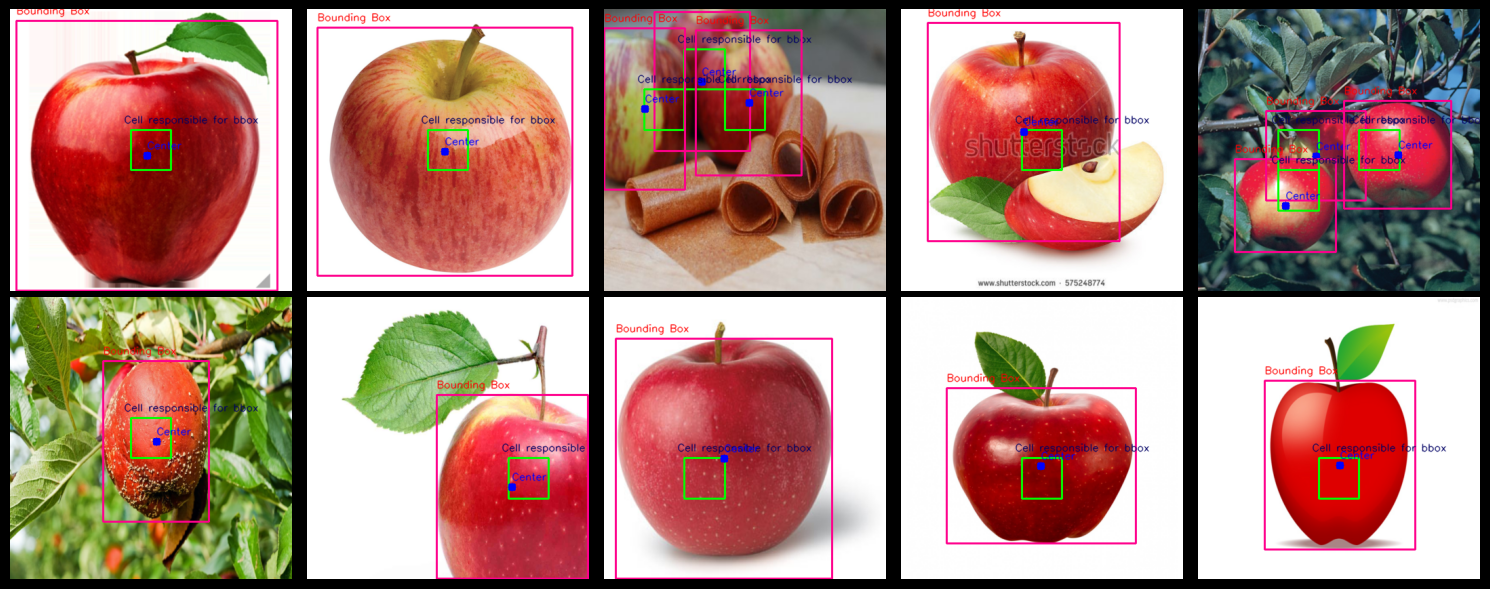

In [133]:
num_images = 10
grid_rows = 2
grid_cols = 5

fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 6))

for i in range(num_images):
    # Get the image and label
    image, label = train_dataset.__getitem__(i)
    
    # Draw bounding boxes on the image
    im = draw_bbox(image, label)
    
    # Determine the grid position
    row = i // grid_cols
    col = i % grid_cols
    
    # Display the image in the grid
    axs[row, col].imshow(im)
    axs[row, col].axis('off')  # Turn off axes for cleaner visualization

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()